In [1]:
from flax import nnx
import jax
import jax.numpy as jnp
import inspeqtor.experimental as sq
from functools import partial
import typing

In [3]:
def get_data_model():
    dt = 2 / 9
    real_qubit_info = sq.data.QubitInformation(
        unit="GHz",
        qubit_idx=0,
        anharmonicity=-0.2,
        frequency=5.0,
        drive_strength=0.1,
    )
    # The drive frequenct is detune by .01%
    detune = 0.0001
    # detune = 0.000
    characterized_qubit_info = sq.data.QubitInformation(
        unit="GHz",
        qubit_idx=0,
        anharmonicity=-0.2,
        frequency=5.0 * (1 + detune),
        drive_strength=0.1,
    )

    control_seq = sq.predefined.get_drag_pulse_v2_sequence(
        qubit_info_drive_strength=characterized_qubit_info.drive_strength,
        min_beta=-5.0,
        max_beta=5.0,
        dt=dt,
    )
    
    signal_fn = sq.physics.signal_func_v5(
        get_envelope=sq.predefined.get_envelope_transformer(control_seq),
        drive_frequency=characterized_qubit_info.frequency,
        dt=dt,
    )
    hamiltonian = partial(
        sq.predefined.transmon_hamiltonian, qubit_info=real_qubit_info, signal=signal_fn
    )
    frame = (jnp.pi * characterized_qubit_info.frequency) * sq.constant.Z
    hamiltonian = sq.physics.auto_rotating_frame_hamiltonian(hamiltonian, frame=frame)

    solver = sq.physics.make_trotterization_solver(
        hamiltonian=hamiltonian,
        control_sequence=control_seq,
        dt=dt,
        trotter_steps=10_000,
    )

    ideal_hamiltonian = partial(
        sq.predefined.transmon_hamiltonian,
        qubit_info=characterized_qubit_info,
        signal=signal_fn,  # Already used the characterized_qubit
    )
    ideal_hamiltonian = sq.physics.auto_rotating_frame_hamiltonian(
        ideal_hamiltonian, frame=frame
    )

    return sq.utils.SyntheticDataModel(
        control_sequence=control_seq,
        qubit_information=characterized_qubit_info,
        dt=dt,
        ideal_hamiltonian=ideal_hamiltonian,
        total_hamiltonian=hamiltonian,
        solver=solver,
        quantum_device=None,
        whitebox=None,
    )

def custom_feature_map_v2(x: jnp.ndarray) -> jnp.ndarray:
    # For angle, we normalize by 2 pi
    x = x.at[..., 0].set(x[..., 0] / (2 * jnp.pi))
    # For beta, we have to shift and normalize later
    x = x.at[..., 1].set((x[..., 1] + 5) / 10)

    return sq.predefined.polynomial_feature_map(x, degree=4)

In [3]:
class Blackbox(nnx.Module):
    def __init__(
        self, shared_layers: list[int], pauli_layers: list[int], *, rngs: nnx.Rngs
    ):
        self.shared_layers = [
            nnx.Linear(in_features=in_features, out_features=out_features, rngs=rngs)
            for in_features, out_features in zip(shared_layers[:-1], shared_layers[1:])
        ]
        self.pauli_layers = {}
        self.unitary_layers = {}
        self.diagonal_layers = {}
        for pauli in ["X", "Y", "Z"]:
            layers = [
                nnx.Linear(
                    in_features=in_features, out_features=out_features, rngs=rngs
                )
                for in_features, out_features in zip(
                    pauli_layers[:-1], pauli_layers[1:]
                )
            ]
            self.pauli_layers[pauli] = layers

            self.unitary_layers[pauli] = nnx.Linear(
                in_features=pauli_layers[-1], out_features=3, rngs=rngs
            )
            self.diagonal_layers[pauli] = nnx.Linear(
                in_features=pauli_layers[-1], out_features=2, rngs=rngs
            )

    def __call__(self, x):
        for layer in self.shared_layers:
            x = nnx.relu(layer(x))

        observables: dict[str, jnp.ndarray] = dict()
        for pauli, pauli_layer in self.pauli_layers.items():
            _x = jnp.copy(x)
            for layer in pauli_layer:
                _x = nnx.relu(layer(_x))

            unitary_param = self.unitary_layers[pauli](_x)
            diagonal_param = self.diagonal_layers[pauli](_x)

            unitary_param = 2 * jnp.pi * nnx.hard_sigmoid(unitary_param)
            diagonal_param = (2 * nnx.hard_sigmoid(diagonal_param)) - 1

            observables[pauli] = sq.model.Wo_2_level_v3(unitary_param, diagonal_param)

        return observables


In [4]:
data_model = get_data_model()

exp_data, control_sequence, _, _ = sq.predefined.generate_experimental_data(
    key=jax.random.key(0),
    hamiltonian=data_model.total_hamiltonian,
    sample_size=1_00,
    strategy=sq.predefined.SimulationStrategy.SHOT,
    get_qubit_information_fn=lambda: data_model.qubit_information,
    get_control_sequence_fn=lambda: data_model.control_sequence,
    method=sq.predefined.WhiteboxStrategy.TROTTER,
    trotter_steps=1_000,
)

whitebox = sq.physics.make_trotterization_solver(
    data_model.ideal_hamiltonian,
    control_sequence,
    exp_data.experiment_config.device_cycle_time_ns,
    1_000,
)

loaded_data = sq.utils.prepare_data(exp_data, control_sequence, whitebox)

In [5]:
key = jax.random.key(0)
key, random_split_key, train_key, prediction_key = jax.random.split(key, 4)
(
    train_control_parameters,
    train_unitaries,
    train_expectation_values,
    test_control_parameters,
    test_unitaries,
    test_expectation_values,
) = sq.utils.random_split(
    random_split_key,
    int(loaded_data.control_parameters.shape[0] * 0.1),  # Test size
    loaded_data.control_parameters,
    loaded_data.unitaries,
    loaded_data.expectation_values,
)

shots = loaded_data.experiment_data.experiment_config.shots

train_data = sq.optimize.DataBundled(
    control_params=custom_feature_map_v2(train_control_parameters),
    unitaries=train_unitaries,
    observables=train_expectation_values,
)

test_data = sq.optimize.DataBundled(
    control_params=custom_feature_map_v2(test_control_parameters),
    unitaries=test_unitaries,
    observables=test_expectation_values,
)

In [29]:
def predictive_fn(model: Blackbox, data: sq.optimize.DataBundled):
    output = model(data.control_params)
    return sq.model.get_predict_expectation_value(
        output, data.unitaries, sq.constant.default_expectation_values_order
    )


def make_loss_fn(predictive_fn, calculate_metric_fn=sq.model.calculate_metric):
    def loss_fn(model: Blackbox, data: sq.optimize.DataBundled):
        expval = predictive_fn(model, data)

        metrics = calculate_metric_fn(data.unitaries, data.observables, expval)
        # Take mean of all the metrics
        metrics = jax.tree.map(jnp.mean, metrics)
        loss = metrics[sq.model.LossMetric.MSEE]

        return loss, metrics

    return loss_fn


loss_fn = make_loss_fn(predictive_fn)


def create_step(
    loss_fn: typing.Callable[
        [Blackbox, sq.optimize.DataBundled], tuple[jnp.ndarray, typing.Any]
    ],
):
    @nnx.jit
    def train_step(
        model: Blackbox,
        optimizer: nnx.Optimizer,
        metrics: nnx.MultiMetric,
        data: sq.optimize.DataBundled,
    ):
        """Train for a single step."""
        model.train()  # Switch to train mode
        grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
        (loss, aux), grads = grad_fn(model, data)
        metrics.update(loss=loss)  # In-place updates.
        optimizer.update(grads)  # In-place updates.

        return loss, aux

    @nnx.jit
    def eval_step(model: Blackbox, metrics: nnx.MultiMetric, data):
        model.eval()
        loss, aux = loss_fn(model, data)
        metrics.update(loss=loss)  # In-place updates.

        return loss, aux

    return train_step, eval_step


def reconstruct_model(model_params, config, Model: type[sq.models.nnx.Blackbox]):
    abstract_model = nnx.eval_shape(lambda: Model(**config, rngs=nnx.Rngs(0)))
    graphdef, abstract_state = nnx.split(abstract_model)
    nnx.replace_by_pure_dict(abstract_state, model_params)

    return nnx.merge(graphdef, abstract_state)

In [6]:
BATCH_SIZE = test_data.control_params.shape[0]
NUM_EPOCH = 2000
dataset_metric = sq.utils.get_dataset_metrics(loaded_data, NUM_EPOCH)

blackbox = sq.models.nnx.WoModel([8], [8], rngs=nnx.Rngs(0))

optimizer = nnx.Optimizer(
    blackbox,
    sq.optimize.get_default_optimizer(dataset_metric.step_for_optimizer),
    wrt=nnx.Param,
)
metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average("loss"),
)

histories = []

loss_fn = sq.models.nnx.make_loss_fn(sq.models.nnx.wo_predictive_fn)
train_step, eval_step = sq.models.nnx.create_step(loss_fn)

for (step, batch_idx, is_last_batch, epoch_idx), (
    batch_p,
    batch_u,
    batch_ex,
) in sq.utils.dataloader(
    (train_data.control_params, train_data.unitaries, train_data.observables),
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCH,
    key=train_key,
):
    
    train_step(
        blackbox,
        optimizer,
        metrics,
        sq.optimize.DataBundled(
            control_params=batch_p, unitaries=batch_u, observables=batch_ex
        ),
    )

    if is_last_batch:
        histories.append(
            sq.optimize.HistoryEntryV3(
                step=step, loss=metrics.compute()["loss"], loop="train", aux={}
            )
        )
        metrics.reset()  # Reset the metrics for the test set.

        eval_step(blackbox, metrics, test_data)
        histories.append(
            sq.optimize.HistoryEntryV3(
                step=step, loss=metrics.compute()["loss"], loop="test", aux={}
            )
        )
        print(step, histories[-1].loss)
        metrics.reset()  # Reset the metrics for the train set.


8 0.34042514336649954
17 0.3400016094713249
26 0.3392942901048993
35 0.33830170531999126
44 0.33704291191059893
53 0.3355162460600592
62 0.33376317620546314
71 0.33175855723402975
80 0.3295532858619641
89 0.327199169084978
98 0.32460879206974536
107 0.32190538687902476
116 0.31896069987872355
125 0.3159809205150532
134 0.31273303671284725
143 0.30921234490040317
152 0.30525342143425993
161 0.3007136304744562
170 0.29526229491798733
179 0.28860945172360425
188 0.28093049985969193
197 0.2719188357889443
206 0.26206330877613504
215 0.25236987396561195
224 0.24259135388590788
233 0.23307903871606386
242 0.2238491161588444
251 0.2147126470610668
260 0.2058601629894227
269 0.19748519545627674
278 0.18932706056974824
287 0.18175586881681213
296 0.17481457615811835
305 0.1673916394649078
314 0.16026480515830036
323 0.15285962766941252
332 0.14669681924453135
341 0.1403139219589666
350 0.13364805413652833
359 0.12839455277580575
368 0.12136929458370996
377 0.11622149526268044
386 0.110948732657

In [19]:
_, state = nnx.split(blackbox)

In [ ]:
_, state = nnx.split(blackbox)

model_params = nnx.to_pure_dict(state)
config = {
    "shared_layers": [8],
    "pauli_layers": [8]
}

model_data = sq.model.ModelData(params=model_params, config=config)
# save and load to and from disk! 

abstract_model = nnx.eval_shape(
    lambda: sq.models.nnx.Blackbox(**config, rngs=nnx.Rngs(0))
)
graphdef, abstract_state = nnx.split(abstract_model)
nnx.replace_by_pure_dict(abstract_state, model_params)
model = nnx.merge(graphdef, abstract_state)

In [ ]:
model = sq.models.nnx.reconstruct_model(model_data.params, model_data.config, sq.models.nnx.WoModel)

In [ ]:
model(test_data.control_params)

{'X': Array([[[-6.05153611e-02+0.j        ,  9.93403263e-01-0.09740559j],
         [ 9.93403263e-01+0.09740559j,  6.05153611e-02+0.j        ]],
 
        [[ 2.42599675e-02+0.j        ,  9.99647439e-01-0.01079129j],
         [ 9.99647439e-01+0.01079129j, -2.42599675e-02+0.j        ]],
 
        [[ 3.26394895e-02+0.j        ,  9.69943660e-01-0.24113059j],
         [ 9.69943660e-01+0.24113059j, -3.26394895e-02+0.j        ]],
 
        [[-6.75704375e-02+0.j        ,  9.94942637e-01-0.07431948j],
         [ 9.94942637e-01+0.07431948j,  6.75704375e-02+0.j        ]],
 
        [[-2.84908700e-02+0.j        ,  9.99253796e-01-0.02607915j],
         [ 9.99253796e-01+0.02607915j,  2.84908700e-02+0.j        ]],
 
        [[-8.28290577e-03+0.j        ,  9.99844987e-01-0.01553691j],
         [ 9.99844987e-01+0.01553691j,  8.28290577e-03+0.j        ]],
 
        [[-4.37113079e-02+0.j        ,  9.91390095e-01-0.12343015j],
         [ 9.91390095e-01+0.12343015j,  4.37113079e-02+0.j        ]],
 
        

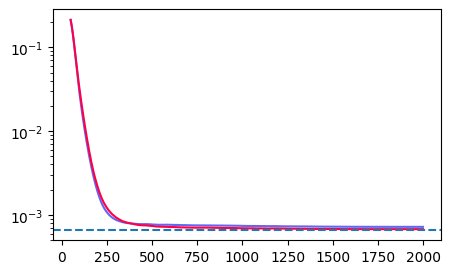

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame([
    {
        "step": entry.step,
        "loop": entry.loop,
        "loss": entry.loss.item(),
    } for entry in histories
])

train_loss = df.query("loop == 'train'")['loss'].to_numpy()
test_loss = df.query("loop == 'test'")['loss'].to_numpy()

fig, ax = plt.subplots(figsize=(5, 3))

iterations = jnp.arange(train_loss.shape[0])
ax = sq.visualization.plot_loss_with_moving_average(
    iterations,
    train_loss,
    ax=ax,
    color="#6366f1",
    label="moving average train MSE[E] Loss",
    annotate_at=[]
)

ax = sq.visualization.plot_loss_with_moving_average(
    iterations,
    test_loss,
    ax=ax,
    color="#ff0048",
    label="moving average Test MSE[E] Loss",
    annotate_at=[]
)

ax.axhline(dataset_metric.var, linestyle="dashed")

ax.set_yscale("log")

In [112]:
dataset_metric.var

0.0006661725584444445